In [78]:
import os
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from keras.utils import to_categorical
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from functools import partial
from sklearn.utils import shuffle


import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
LL = ['LONGITUDE', 'LATITUDE']
LLBF = LL + ['BUILDINGID', 'FLOOR']

def duplicate(df, n) :
    df_result = pd.DataFrame()
    for c in df.columns :
        df_result[c] = df[c].repeat(n)
    df_result = df_result.reset_index(drop=True)
    return df_result

def pairing(df_base, df_add) :
    n = len(df_base)
    df_base = duplicate(df_base, len(df_add))
    df_base['LONGITUDE_SOURCE'] = pd.np.tile(df_add.LONGITUDE, n) 
    df_base['LATITUDE_SOURCE'] = pd.np.tile(df_add.LATITUDE, n) 
    df_base['SIGNAL_SOURCE'] = pd.np.tile(df_add.SIGNAL, n) 
    return df_base

def merge_agg(df, group, value, aggregates, columns=None) :
    df_count = pd.DataFrame(df.groupby(group)[value].agg(aggregates)).reset_index()
    df_count.columns = group + aggregates if columns is None else group + columns
    df = df.merge(df_count, on=group, how="left").fillna(0)
    return df

def restructure(df) :
    df_final = pd.DataFrame()
    for i in range(1,521) :
        AP = 'WAP%03d' % i
        df_temp = df[[AP]+LLBF]
        df_temp = df_temp.rename(columns={AP : 'SIGNAL'})
        df_temp['WAP'] = i
        
        df_final = df_final.append(df_temp, ignore_index=True)
    df_final = df_final.drop_duplicates().reset_index(drop=True)
    return df_final

def get_strongest(df) :
    df_max = pd.DataFrame()
    for WAP in range(1,521) :
        df_temp = df[df['WAP'] == WAP].reset_index(drop=True)
        max_val = df_temp['SIGNAL'].max()
        
        df_temp = df_temp[df_temp['SIGNAL'] == max_val]
        df_temp = df_temp.drop_duplicates().reset_index(drop=True)
        
        df_max = df_max.append(df_temp).reset_index(drop=True)

    return df_max
    
    
def generate(df, df_max, building_id, floor):
    curr_df = df[filter(df, building_id, floor)].reset_index(drop=True)
    curr_df_max = df_max[filter(df_max, building_id, floor)].reset_index(drop=True)
    max_curr_floor = curr_df_max['WAP'].unique()

    df_final = pd.DataFrame()
    for i in max_curr_floor :
        df_temp = curr_df[curr_df['WAP']==i][['WAP', 'LONGITUDE', 'LATITUDE', 'SIGNAL']]

        #add pairing
        curr_df_max_by_WAP = curr_df_max[curr_df_max['WAP']==i]
        df_temp = pairing(df_temp, curr_df_max_by_WAP)
        df_temp['DIFF_SIGNAL'] = df_temp['SIGNAL_SOURCE'] - df_temp['SIGNAL']

        df_final = df_final.append(df_temp, ignore_index=True)

    return df_final, curr_df_max

def generate2(df, df_max, floor):
    curr_df = df[(df['FLOOR']==floor)].reset_index(drop=True)
    curr_df_max = df_max[(df_max['FLOOR']==floor)].reset_index(drop=True)
    max_curr_floor = curr_df_max['WAP'].unique()

    df_final = pd.DataFrame()
    for i in max_curr_floor :
        df_temp = curr_df[curr_df['WAP']==i][['WAP', 'LONGITUDE', 'LATITUDE', 'SIGNAL']]

        #add pairing
        curr_df_max_by_WAP = curr_df_max[curr_df_max['WAP']==i]
        df_temp = pairing(df_temp, curr_df_max_by_WAP)
        df_temp['DIFF_SIGNAL'] = df_temp['SIGNAL_SOURCE'] - df_temp['SIGNAL']

        df_final = df_final.append(df_temp, ignore_index=True)

    return df_final, curr_df_max

def filter(df, bid, fid) :
    return (df['BUILDINGID']==bid) & (df['FLOOR']==fid)

In [3]:
# df_train = pd.DataFrame.from_csv('../data/ujiindoorloc/trainingData.csv').reset_index()
# df_val = pd.DataFrame.from_csv('../data/ujiindoorloc/validationData.csv').reset_index()

# df_restructure_train = restructure(df_train)
# df_restructure_train.to_csv('../data/ujiindoorloc/restructured_train.csv')
# df_restructure_val = restructure(df_val)
# df_restructure_val.to_csv('../data/ujiindoorloc/restructured_val.csv')

# df_restructure = df_restructure_train.append(df_restructure_val, ignore_index=True)
# df_restructure.to_csv('../data/ujiindoorloc/restructured_all.csv')

df_restructure_train = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_train.csv')
# df_restructure_val = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_val.csv')
# df_restructure = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_all.csv')

df_restructure_train['LONGITUDE'] = minmax_scale(df_restructure_train['LONGITUDE'], feature_range=(-1, 1))
df_restructure_train['LATITUDE'] = minmax_scale(df_restructure_train['LATITUDE'], feature_range=(-1, 1))

# df_restructure['LONGITUDE'] = minmax_scale(df_restructure['LONGITUDE'], feature_range=(-1, 1))
# df_restructure['LATITUDE'] = minmax_scale(df_restructure['LATITUDE'], feature_range=(-1, 1))

# df_restructure_val['LONGITUDE'] = minmax_scale(df_restructure_val['LONGITUDE'], feature_range=(-1, 1))
# df_restructure_val['LATITUDE'] = minmax_scale(df_restructure_val['LATITUDE'], feature_range=(-1, 1))

/home/tryan/miniconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


In [4]:
print('dataset len ', len(df_restructure_train[LLBF].drop_duplicates()))

for bid in range(3) :
    for fid in range(5) :
        if fid == 4 and bid != 2:
            continue
        
        temp = df_restructure_train[filter(df_restructure_train, bid, fid)]
        print(bid, fid, 'locations: ', len(temp[LLBF].drop_duplicates()))

dataset len  933
0 0 locations:  54
0 1 locations:  67
0 2 locations:  70
0 3 locations:  68
1 0 locations:  76
1 1 locations:  60
1 2 locations:  79
1 3 locations:  50
2 0 locations:  67
2 1 locations:  89
2 2 locations:  73
2 3 locations:  113
2 4 locations:  67


### replace, scale, calculate min signal  

In [5]:
LLBFW = LLBF + ['WAP']
df_restructure_train['SIGNAL'].replace(100, -200, inplace=True)
df_restructure_train['SIGNAL'] = minmax_scale(df_restructure_train['SIGNAL'], feature_range=(-1, 1))
df_agg_max = merge_agg(df_restructure_train, LLBFW, 'SIGNAL', ['min'], ['MIN_SIGNAL'])

In [6]:
print(len(df_agg_max))

635118


### avg signal in each detected location 

In [7]:
detected_filter = df_agg_max['MIN_SIGNAL']>-1
df_detected = df_agg_max[detected_filter].drop('MIN_SIGNAL', axis=1)
df_detected = merge_agg(df_detected, LLBFW, 'SIGNAL', ['mean'])
df_detected = df_detected.drop('SIGNAL', axis=1).rename(columns={'mean' : 'SIGNAL'})
df_detected = df_detected.drop_duplicates().reset_index(drop=True)

In [8]:
df_not_detected = df_agg_max[~detected_filter]
df_not_detected = df_not_detected.drop('SIGNAL', axis=1).rename(columns={'MIN_SIGNAL' : 'SIGNAL'})
df_not_detected = df_not_detected.drop_duplicates().reset_index(drop=True)

In [9]:
print(len(df_detected)+len(df_not_detected))

485160


### get source location 

In [10]:
df_max = get_strongest(df_detected)

# ==========Start checking 

In [11]:
wap_count = {}
print('all len ', len(df_max.WAP.unique()))
for bid in range(3) :
    wap_count[bid] = {}
    for fid in range(5) :
        temp = df_max[(df_max.BUILDINGID==bid)&(df_max.FLOOR==fid)]
        print(bid, fid, 'WAP source :', len(temp.WAP.unique()))  
        wap_count[bid][fid] = len(temp.WAP.unique()) 

all len  259
0 0 WAP source : 11
0 1 WAP source : 19
0 2 WAP source : 14
0 3 WAP source : 12
0 4 WAP source : 0
1 0 WAP source : 61
1 1 WAP source : 23
1 2 WAP source : 22
1 3 WAP source : 18
1 4 WAP source : 0
2 0 WAP source : 13
2 1 WAP source : 15
2 2 WAP source : 14
2 3 WAP source : 16
2 4 WAP source : 21


In [12]:
LLWM = LL + ['WAP', 'MIN_SIGNAL']
for bid in range(3) :
    for fid in range(5) :
        if fid==4 and bid!=2 :
            continue
            
        max_curr_floor = df_max[filter(df_max, bid, fid)]['WAP'].unique()
        all_data = df_agg_max[filter(df_agg_max, bid, fid)&(df_agg_max.WAP.isin(max_curr_floor))]
        all_data = all_data[LLWM].drop_duplicates()
        
        detected = df_detected[filter(df_detected, bid, fid)]
        detected = detected[(detected.WAP.isin(max_curr_floor))]

        not_detected = df_not_detected[filter(df_not_detected, bid, fid)]
        not_detected = not_detected[(not_detected.WAP.isin(max_curr_floor))]
        
        print(bid, fid, len(max_curr_floor), 'all data:', len(all_data), 
              'detected:', len(detected), 'not detected:', len(not_detected))

# TODO really coverage hole loc

0 0 11 all data: 594 detected: 129 not detected: 465
0 1 19 all data: 1273 detected: 268 not detected: 1005
0 2 14 all data: 980 detected: 159 not detected: 821
0 3 12 all data: 816 detected: 268 not detected: 548
1 0 61 all data: 4636 detected: 475 not detected: 4161
1 1 23 all data: 1380 detected: 220 not detected: 1160
1 2 22 all data: 1738 detected: 290 not detected: 1448
1 3 18 all data: 900 detected: 113 not detected: 787
2 0 13 all data: 871 detected: 162 not detected: 709
2 1 15 all data: 1335 detected: 244 not detected: 1091
2 2 14 all data: 1022 detected: 241 not detected: 781
2 3 16 all data: 1808 detected: 365 not detected: 1443
2 4 21 all data: 1407 detected: 445 not detected: 962


# ==========End checking 

# select building ID and floor ID 

In [13]:
def get_train_val(bid=0, fid=0, r=0) :
    max_curr_floor = df_max[filter(df_max, bid, fid)]['WAP'].unique()

    detected = df_detected[filter(df_detected, bid, fid)]
    detected = detected[(detected.WAP.isin(max_curr_floor))]

    not_detected = df_not_detected[filter(df_not_detected, bid, fid)]
    not_detected = not_detected[(not_detected.WAP.isin(max_curr_floor))]

    detected_train, detected_val = train_test_split(detected, train_size=0.7, random_state=r)
    not_detected_train, not_detected_val = train_test_split(not_detected, train_size=0.7, random_state=r)

    df_train = detected_train.append(not_detected_train)
    df_train = shuffle(df_train, random_state=r)

    df_val = detected_val.append(not_detected_val)
    df_val = shuffle(df_val, random_state=r)

    df_train, _ = generate(df_train, df_max, building_id=bid, floor=fid)
    df_val, _ = generate(df_val, df_max, building_id=bid, floor=fid)

    print('detected_train', 'detected_val', 'not_detected_train', 'not_detected_val')
    print(len(detected_train), len(detected_val), len(not_detected_train), len(not_detected_val))
    print('wap detected_train', 'wap detected_val', 'wap not_detected_train', 'wap not_detected_val')
    print(len(detected_train.WAP.unique()), len(detected_val.WAP.unique()), 
          len(not_detected_train.WAP.unique()), len(not_detected_val.WAP.unique()))
    print('train', 'val')
    print(len(df_train), len(df_val))
    
    return df_train, df_val

# Start Training

In [14]:
class UJIIndoorLocDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = self.df.drop(['WAP', 'SIGNAL', 'SIGNAL_SOURCE', 'DIFF_SIGNAL'], axis=1).values
        self.labels = self.df['DIFF_SIGNAL'].values 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx,:2], self.features[idx,2:], self.labels[idx]
#         return self.features[idx], self.labels[idx]

In [15]:
batch_size = 64

def get_loader(df_train, df_val) :
    train_dataset = UJIIndoorLocDataset(df_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = UJIIndoorLocDataset(df_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    return train_dataloader, val_dataloader

In [16]:
# https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.Dropout(0.2),
#             nn.Linear(32, 32),
#             nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 3))

    def forward(self, x1, x2=None, predict=False):
        out1 = self.encoder(x1)
        
        if predict :
            return out1
        
        out2 = self.encoder(x2)
        distance = torch.sqrt(torch.sum((out1 - out2)**2, dim=1))
        return distance
    
def exp_lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epoch=5):
    if epoch % lr_decay_epoch:
        for param_group in optimizer.param_groups:
            new_lr = param_group['lr'] / (1+lr_decay*epoch)
            param_group['lr'] = new_lr
    return optimizer

In [17]:
def get_model(num_epochs=150, lr=1e-1, weight_decay=1e-5, lr_decay=1e-1, lr_decay_epoch=5):
    model = autoencoder().to(device).float()
    criterion = nn.MSELoss().to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, 
                                weight_decay=weight_decay)
    optimizer = exp_lr_scheduler(optimizer, num_epochs, 
                                 lr_decay=lr_decay, lr_decay_epoch=lr_decay_epoch)
    return model, criterion, optimizer

# Train 

In [18]:
def train(model, criterion, optimizer, train_dataloader, num_epochs=150, show=False):
    losses = []
    min_loss = 1
    best_model = model
    for epoch in range(num_epochs):
        for features1, features2, labels in train_dataloader:
            features1 = features1.to(device)
            features2 = features2.to(device)
            labels = labels.to(device)
            # ===================forward=====================
            distance = model(features1.float(), features2.float())
            loss = criterion(distance, labels.float())
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        losses.append(loss.item())

        if losses[-1] < min_loss :
            min_loss = losses[-1]
            best_model = copy.deepcopy(model) 

    best_model = best_model.eval()
    
    if show :
        print(bid, fid, 'model loss start {:.4f} best {:.4f}'.format(losses[0], min_loss))
        
        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.xlabel('Iterations', fontsize=20)
        plt.ylabel('MSE', fontsize=20)
        plt.tick_params(labelsize=15)
        plt.title('MSE loss in Training Phase', fontsize=25)
        plt.grid(True)
        plt.show()
    
    return best_model

In [19]:
def evaluate(best_model, val_dataloader) :
    distance = np.empty(0)
    for features1, features2, labels in val_dataloader:
        features1 = features1.to(device)
        features2 = features2.to(device)
        labels = labels.to(device)
        # ===================forward=====================
        out = best_model(features1.float(), features2.float())
        out = out.cpu().detach().numpy()
        distance = np.append(distance, out, axis=0)
        
    return distance

In [103]:
def encoder_result(df_train, df_val, lr=1e-1, lr_decay=1e-1, 
                   lr_decay_epoch=5, weight_decay=1e-5, show=False) :
    
    train_dataloader, val_dataloader = get_loader(df_train, df_val)
    
    model, criterion, optimizer = get_model(num_epochs=100, 
                                            lr=lr, lr_decay=lr_decay,
                                            weight_decay=weight_decay,  
                                            lr_decay_epoch=int(lr_decay_epoch))

    best_model = train(model, criterion, optimizer, 
                       train_dataloader,
                       num_epochs=100, 
                       show=show)

    distance = evaluate(best_model, val_dataloader)
            
    detected = df_val[(df_val.SIGNAL>-1)].index.values
    max_distance = 0.1*distance[detected].max()
    detected = distance < max_distance
    
    mse = mean_squared_error(df_val['DIFF_SIGNAL'], distance)
    acc = np.mean((df_val['SIGNAL'] > -1) == detected)

    if show :
        print('encoder', 'mse', mse, 'acc', acc)
        return best_model, detected
    
    return -mse

In [136]:
def plot_encoder(df_val_enc) :
    df_val_enc['REAL_DETECTED'] = df_val_enc['SIGNAL']>-1 
    df_enc=df_val_enc.groupby(LL).sum()[['DETECTED', 'REAL_DETECTED']].reset_index()
    df_enc['DIFF'] = (df_enc['DETECTED']-df_enc['REAL_DETECTED']).abs()
    plot(df_enc)

def plot(df) :
    cm = plt.cm.get_cmap('RdYlGn_r')
    x = df['LONGITUDE']
    y = df['LATITUDE']
    fig = plt.figure(figsize=(10,5))
    sc = plt.scatter(x, y, c=df.DIFF, s=35, cmap=cm)
    sc = plt.colorbar(sc)
    sc.ax.tick_params(labelsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

# Comparison 

In [94]:
def knn_result(df_train, df_val) :
    x_train = df_train[LL+['WAP']].values
    x_val = df_val[LL+['WAP']].values

    y_train = df_train['SIGNAL']
    y_val = df_val['SIGNAL']

    knn = KNeighborsRegressor(n_neighbors=4)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    
    y_train = df_train['SIGNAL'] == -1
    y_val = df_val['SIGNAL'] == -1

    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    acc = np.mean(y_val == y_pred)
    
    print('knn', 'mse', mse, 'acc', acc)
    return y_pred
    
def svm_result(df_train, df_val) :
    x_train = df_train[LL+['WAP']].values
    x_val = df_val[LL+['WAP']].values

    y_train = df_train['SIGNAL']
    y_val = df_val['SIGNAL']

    svm = SVR(gamma='scale')
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    
    y_train = df_train['SIGNAL'] == -1
    y_val = df_val['SIGNAL'] == -1

    svm = SVC(gamma='scale')
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_val)
    acc = np.mean(y_val == y_pred)
    
    print('svm', 'mse', mse, 'acc', acc)
    return y_pred

def dt_result(df_train, df_val) :
    x_train = df_train[LL+['WAP']].values
    x_val = df_val[LL+['WAP']].values

    y_train = df_train['SIGNAL']
    y_val = df_val['SIGNAL']

    dt = DecisionTreeRegressor()
    dt.fit(x_train, y_train)
    y_pred = dt.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    
    y_train = df_train['SIGNAL'] == -1
    y_val = df_val['SIGNAL'] == -1

    svm = DecisionTreeClassifier()
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_val)
    acc = np.mean(y_val == y_pred)
    
    print('decision tree', 'mse', mse, 'acc', acc)
    return y_pred

In [95]:
def plot_other(df_val, is_detected) :
    df_val_2 = df_val.copy()
    df_val_2['DETECTED'] = is_detected
    df_val_2['REAL_DETECTED'] = df_val_2['SIGNAL']>-1 
    
    df_val_2=df_val_2.groupby(LL).sum()
    df_val_2=df_val_2[['DETECTED', 'REAL_DETECTED']]
    df_val_2=df_val_2.reset_index()
    df_val_2['DIFF'] = (df_val_2['DETECTED']-df_val_2['REAL_DETECTED']).abs()
    plot(df_val_2)

# Optimize 

In [42]:
def optimize_encoder(df_train, df_val):
    encoder_fn = partial(encoder_result, 
                         df_train=df_train, 
                         df_val=df_val)
    
    optimizer = BayesianOptimization(
        f=encoder_fn,
        pbounds={"lr": (1e-3, 5e-1), 
                 "lr_decay": (1e-5, 5e-1), 
                 "lr_decay_epoch": (5, 50), 
                 "weight_decay": (1e-5, 5e-1)},
        random_state=2,
        verbose=2
    )
    optimizer.maximize(n_iter=3)
    return optimizer

# Loop 

detected_train detected_val not_detected_train not_detected_val
90 39 325 140
wap detected_train wap detected_val wap not_detected_train wap not_detected_val
11 10 11 11
train val
415 179
|   iter    |  target   |    lr     | lr_decay  | lr_dec... | weight... |
-------------------------------------------------------------------------
|  1        | -0.8849   |  0.2186   |  0.01297  |  29.73    |  0.2177   |
|  2        | -0.7896   |  0.2108   |  0.1652   |  14.21    |  0.3096   |
|  3        | -0.7535   |  0.1505   |  0.1334   |  32.95    |  0.2646   |
|  4        | -1.371    |  0.06816  |  0.2568   |  13.3     |  0.3927   |
|  5        | -0.7459   |  0.4271   |  0.2471   |  43.1     |  0.03983  |
|  6        | -0.5877   |  0.5      |  1e-05    |  17.61    |  1e-05    |
|  7        | -1.541    |  0.001    |  1e-05    |  49.65    |  0.5      |
|  8        | -1.575    |  0.001    |  0.5      |  38.13    |  0.5      |
0 0 model loss start 0.8880 best 0.0871


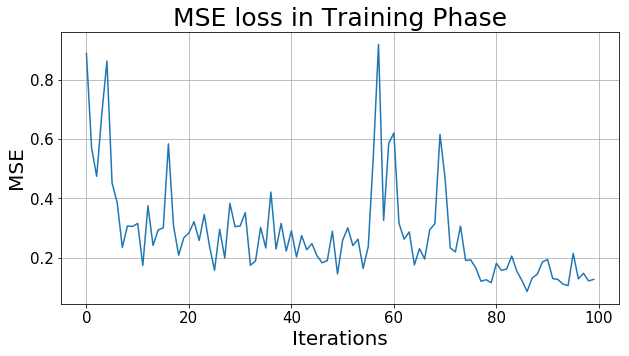

encoder mse 0.612230500891831 acc 0.7206703910614525
knn mse 0.12321691023760112 acc 0.888268156424581
svm mse 0.3537559988247627 acc 0.7821229050279329
decision tree mse 0.07148610428748171 acc 0.9553072625698324


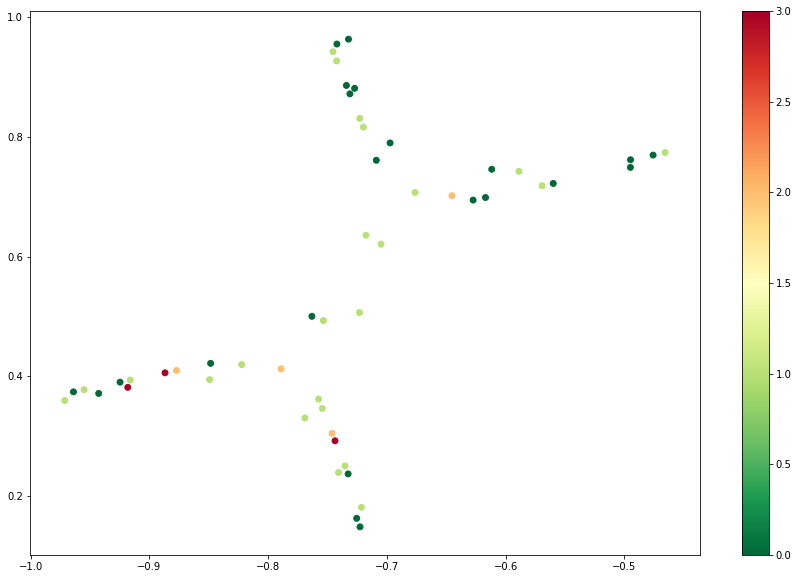

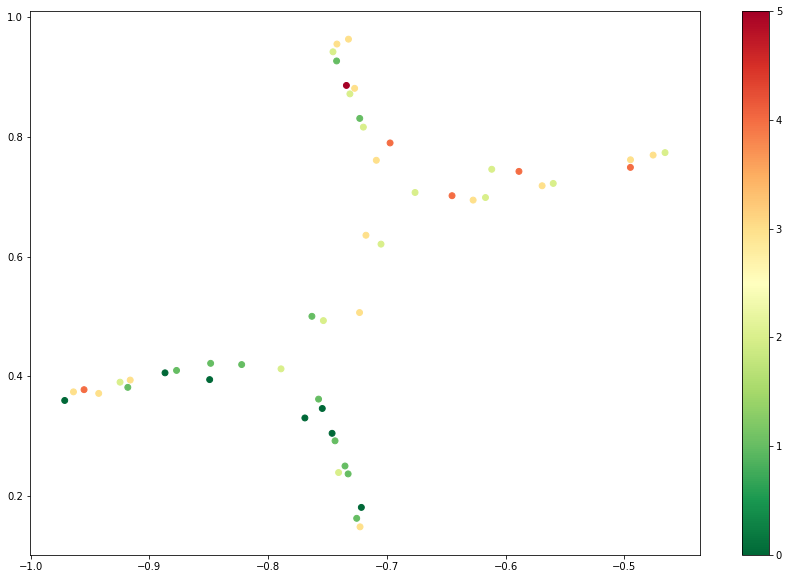

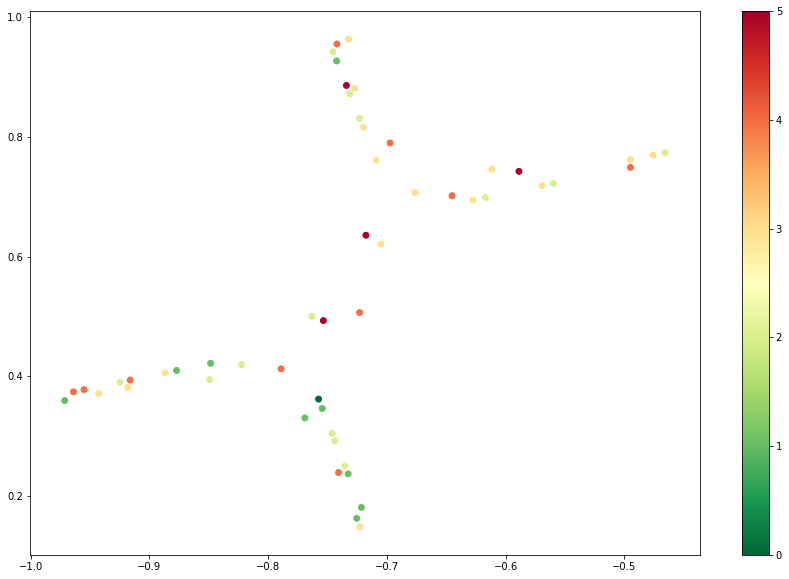

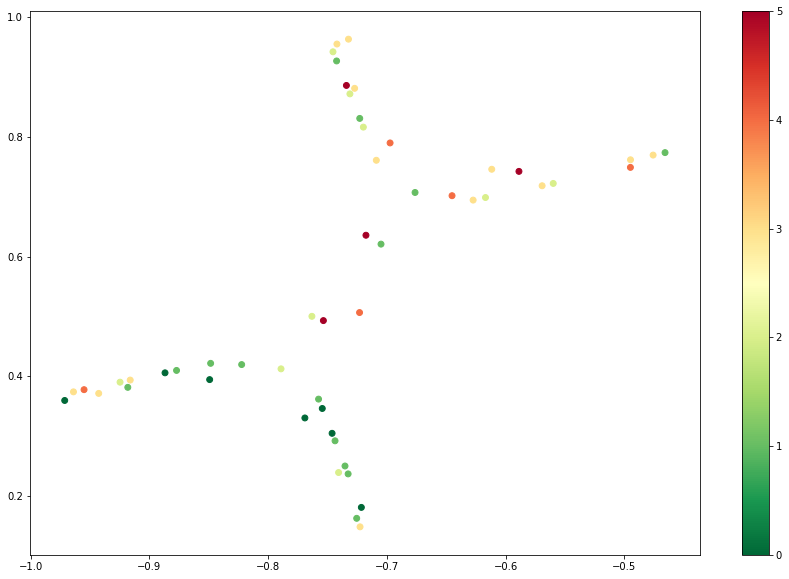

In [104]:
for bid in range(3) :
    for fid in range(5) :
        if fid == 4 and bid != 2:
            continue
            
        df_train, df_val = get_train_val(bid, fid)
        
        opt = optimize_encoder(df_train, df_val)
        best_model, enc_pred = encoder_result(df_train, df_val, 
                                              show=True, **opt.max['params'])
        
        knn_pred = knn_result(df_train, df_val)
        svm_pred = svm_result(df_train, df_val)
        dt_pred = dt_result(df_train, df_val)
        
        plot_other(df_val, enc_pred)
        plot_other(df_val, knn_pred)
        plot_other(df_val, svm_pred)
        plot_other(df_val, dt_pred)
        print('')
        print('')
        break 
    break

In [108]:
temp = df_val['LONGITUDE'].sort_values().diff()
min_x = min(df_val['LONGITUDE'])
max_x = max(df_val['LONGITUDE'])
gap_x = min(temp[temp>0])
gap_x = 0.01
print(min_x, max_x, gap_x)
x = np.arange(min_x, max_x, gap_x)

temp = df_val['LATITUDE'].sort_values().diff()
min_y = min(df_val['LATITUDE'])
max_y = max(df_val['LATITUDE'])
gap_y = min(temp[temp>0])
gap_y = 0.01
print(min_y, max_y, gap_y)
y = np.arange(min_y, max_y, gap_y)

len(x), len(y)

-0.9712439389286942 -0.4658549749244827 0.01
0.14791530311777024 0.9636543189917575 0.01


(51, 82)

In [109]:
features = np.zeros((len(x)*len(y), 2))
features[:, 0] = np.tile(x, len(y))
features[:, 1] = np.repeat(y, len(x))
np.array(features).shape

(4182, 2)

Text(0.5, 0, 'z')

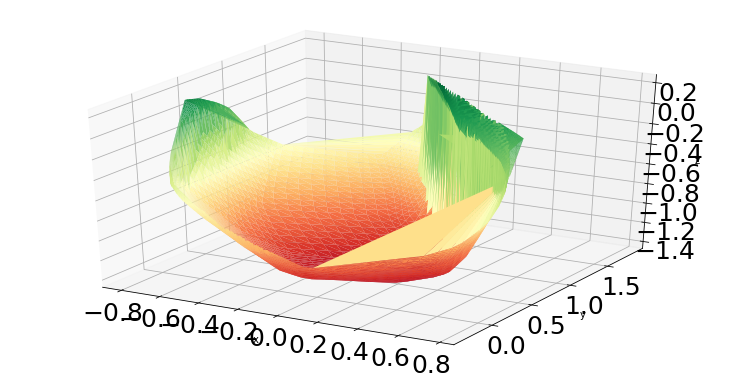

In [110]:
features = torch.tensor(features).to(device).float()
out = best_model(features, predict=True)
out = out.cpu().detach().numpy()

fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.tick_params(labelsize=25)

ax.plot_trisurf(out[:, 0], out[:, 1], out[:, 2], cmap=cm.RdYlGn)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

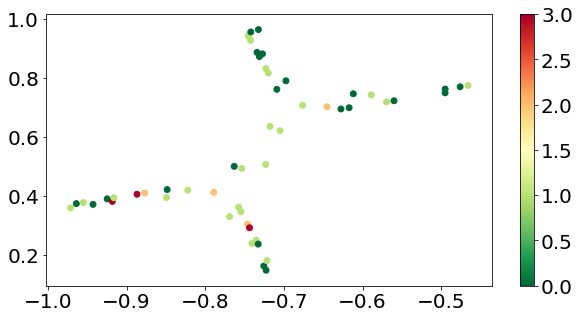

In [137]:
plot_other(df_val, enc_pred)

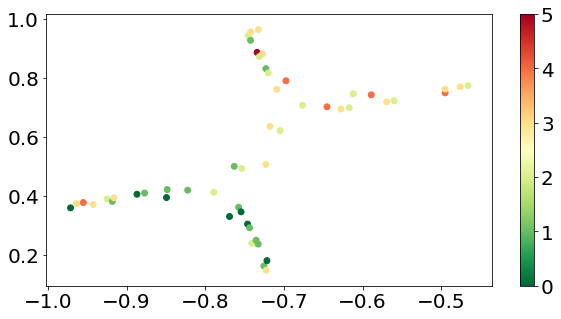

In [138]:
plot_other(df_val, knn_pred)

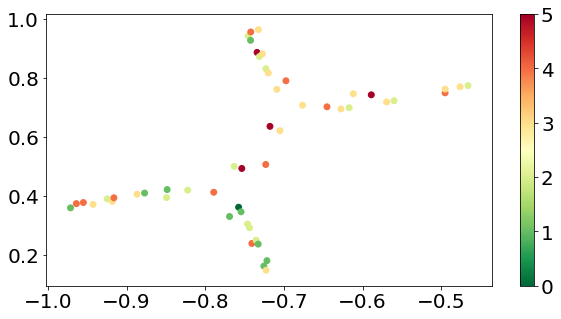

In [139]:
plot_other(df_val, svm_pred)

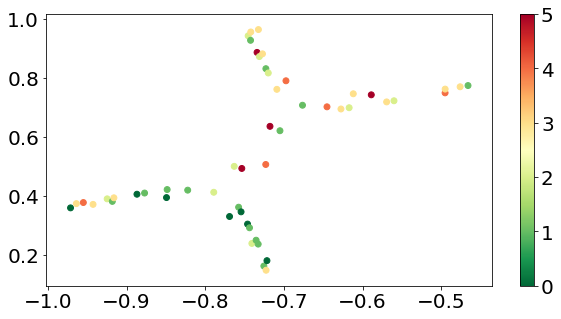

In [140]:
plot_other(df_val, dt_pred)